# Kaggle Titanic Competition by Craig Follmer

Data Dictionary

Variable	Definition	Key
survival	Survival	0 = No, 1 = Yes
pclass	Ticket class	1 = 1st, 2 = 2nd, 3 = 3rd
sex	Sex	
Age	Age in years	
sibsp	# of siblings / spouses aboard the Titanic	
parch	# of parents / children aboard the Titanic	
ticket	Ticket number	
fare	Passenger fare	
cabin	Cabin number	
embarked	Port of Embarkation	C = Cherbourg, Q = Queenstown, S = Southampton
Variable Notes

pclass: A proxy for socio-economic status (SES)
1st = Upper
2nd = Middle
3rd = Lower

age: Age is fractional if less than 1. If the age is estimated, is it in the form of xx.5

sibsp: The dataset defines family relations in this way...
Sibling = brother, sister, stepbrother, stepsister
Spouse = husband, wife (mistresses and fiancés were ignored)

parch: The dataset defines family relations in this way...
Parent = mother, father
Child = daughter, son, stepdaughter, stepson
Some children travelled only with a nanny, therefore parch=0 for them.

In [1]:
#import all the packages needed for this analysis
import pandas as pd
import numpy as np
from sklearn.preprocessing import LabelEncoder
import random
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
#python read test data set for exploratory analysis
#import pandas as pd

df_train = pd.read_csv("./train.csv",sep=',',header=0,na_values = [' ','.'])
df_test = pd.read_csv("./test.csv",sep=',',header=0,na_values = [' ','.'])
#Create a flag for Train and Test Data sets in the data
df_train['DType']='Train'
df_test['DType']='Test'
#Combined both Train and Test Data set
df_fulldata = pd.concat([df_train,df_test],axis=0,sort=False)
pd.DataFrame(df_fulldata)
print(df_fulldata.head(10))

   PassengerId  Survived  Pclass  \
0            1       0.0       3   
1            2       1.0       1   
2            3       1.0       3   
3            4       1.0       1   
4            5       0.0       3   
5            6       0.0       3   
6            7       0.0       1   
7            8       0.0       3   
8            9       1.0       3   
9           10       1.0       2   

                                                Name     Sex   Age  SibSp  \
0                            Braund, Mr. Owen Harris    male  22.0      1   
1  Cumings, Mrs. John Bradley (Florence Briggs Th...  female  38.0      1   
2                             Heikkinen, Miss. Laina  female  26.0      0   
3       Futrelle, Mrs. Jacques Heath (Lily May Peel)  female  35.0      1   
4                           Allen, Mr. William Henry    male  35.0      0   
5                                   Moran, Mr. James    male   NaN      0   
6                            McCarthy, Mr. Timothy J    male  54

In [3]:
#Explore the DataFrame
df_fulldata.describe()

,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare
count,1309.000000,891.000000,1309.000000,1046.000000,1309.000000,1309.000000,1308.000000
mean,655.000000,0.383838,2.294882,29.881138,0.498854,0.385027,33.295479
std,378.020061,0.486592,0.837836,14.413493,1.041658,0.865560,51.758668
min,1.000000,0.000000,1.000000,0.170000,0.000000,0.000000,0.000000
25%,328.000000,0.000000,2.000000,21.000000,0.000000,0.000000,7.895800
50%,655.000000,0.000000,3.000000,28.000000,0.000000,0.000000,14.454200
75%,982.000000,1.000000,3.000000,39.000000,1.000000,0.000000,31.275000
max,1309.000000,1.000000,3.000000,80.000000,8.000000,9.000000,512.329200


In [4]:
#Check Data Types of Columns
df_fulldata.dtypes

PassengerId      int64
Survived       float64
Pclass           int64
Name            object
Sex             object
Age            float64
SibSp            int64
Parch            int64
Ticket          object
Fare           float64
Cabin           object
Embarked        object
DType           object
dtype: object

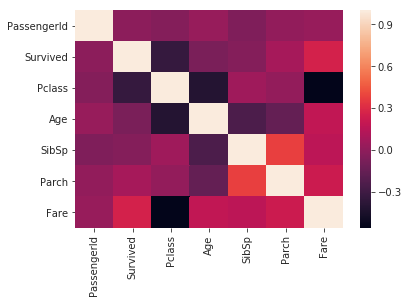

In [5]:
#Compare correlations of any of the fields with Seaborne plot
sns.set_style("ticks")
%matplotlib inline
corr = df_fulldata.corr()
sns.heatmap(corr, 
        xticklabels=corr.columns,
        yticklabels=corr.columns)

In [6]:
# create Title feature from beginning of Names and add to full dataset
pre_title = df_fulldata["Name"].str.split(".", n = 1, expand = True)
pd.DataFrame(pre_title)
pre_title2 = pre_title[0].str.split(", ", n = 1, expand = True)
pd.DataFrame(pre_title2)
df_fulldata["Title"] = pre_title2[1]
df_fulldata.head(10)

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,DType,Title
0,1,0.0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S,Train,Mr
1,2,1.0,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C,Train,Mrs
2,3,1.0,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S,Train,Miss
3,4,1.0,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S,Train,Mrs
4,5,0.0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S,Train,Mr
5,6,0.0,3,"Moran, Mr. James",male,NaN,0,0,330877,8.4583,NaN,Q,Train,Mr
6,7,0.0,1,"McCarthy, Mr. Timothy J",male,54.0,0,0,17463,51.8625,E46,S,Train,Mr
7,8,0.0,3,"Palsson, Master. Gosta Leonard",male,2.0,3,1,349909,21.0750,NaN,S,Train,Master
8,9,1.0,3,"Johnson, Mrs. Oscar W (Elisabeth Vilhelmina Berg)",female,27.0,0,2,347742,11.1333,NaN,S,Train,Mrs
9,10,1.0,2,"Nasser, Mrs. Nicholas (Adele Achem)",female,14.0,1,0,237736,30.0708,NaN,C,Train,Mrs


In [7]:
df_fulldata.dtypes

PassengerId      int64
Survived       float64
Pclass           int64
Name            object
Sex             object
Age            float64
SibSp            int64
Parch            int64
Ticket          object
Fare           float64
Cabin           object
Embarked        object
DType           object
Title           object
dtype: object

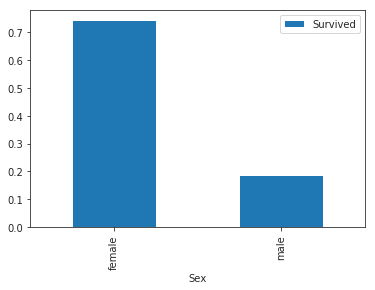

In [8]:
# Explore Age, Sex and PClass as best predictors of survival
# Start with Sex and PClass by visualzing the data
sex_pivot = df_fulldata.pivot_table(index="Sex",values="Survived")
sex_pivot
sex_pivot.plot.bar()
#plt.show()

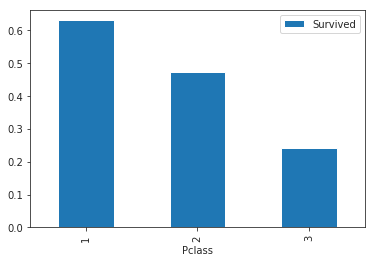

In [9]:
# Visualize the relationship between PClass and Survived
pclass_pivot = df_fulldata.pivot_table(index="Pclass",values="Survived")
pclass_pivot
pclass_pivot.plot.bar()
#plt.show()

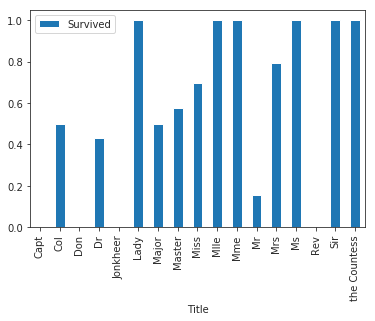

In [10]:
# Visualize the relationship between Title and Survived
title_pivot = df_fulldata.pivot_table(index="Title",values="Survived")
title_pivot
title_pivot.plot.bar()
#plt.show()

In [11]:
# Explore the Age column (as is not categorical needs deeper investigation)
df_fulldata['Age'].describe()

count    1046.000000
mean       29.881138
std        14.413493
min         0.170000
25%        21.000000
50%        28.000000
75%        39.000000
max        80.000000
Name: Age, dtype: float64

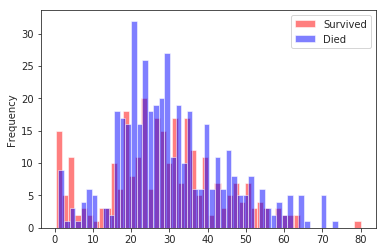

In [12]:
# Build Histograms to compare age of passengers by survived and died
survived = df_fulldata[df_fulldata["Survived"] == 1]
died = df_fulldata[df_fulldata["Survived"] == 0]
survived["Age"].plot.hist(alpha=0.5,color='red',bins=50)
died["Age"].plot.hist(alpha=0.5,color='blue',bins=50)
plt.legend(['Survived','Died'])
plt.show()

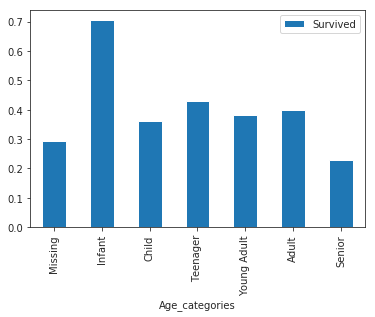

In [13]:
# Use cut function to create buckets for Age by 7 different categories and then visualize the data in each of these bins
def process_age(df,cut_points,label_names):
    df["Age"] = df["Age"].fillna(-0.5)
    df["Age_categories"] = pd.cut(df["Age"],cut_points,labels=label_names)
    return df

cut_points = [-1,0, 5, 12, 18, 35, 60, 100]
label_names = ["Missing", 'Infant', "Child", 'Teenager', "Young Adult", 'Adult', 'Senior']

df_fulldata = process_age(df_fulldata,cut_points,label_names)

age_cat_pivot = df_fulldata.pivot_table(index="Age_categories",values="Survived")
age_cat_pivot.plot.bar()
plt.show()

In [14]:
# Create dummie variables for Pclass attribute to remove 1,2,3 integer relationship
column_name = "Pclass"
df = df_fulldata
dummies = pd.get_dummies(df[column_name],prefix=column_name)
dummies.head()

,Pclass_1,Pclass_2,Pclass_3
0,0,0,1
1,1,0,0
2,0,0,1
3,1,0,0
4,0,0,1


In [15]:
# Now that we know dummies works, create function to create and add these fields to the dataframe
def create_dummies(df,column_name):
    dummies = pd.get_dummies(df[column_name],prefix=column_name)
    df = pd.concat([df,dummies],axis=1)
    return df

df_fulldata = create_dummies(df_fulldata,"Pclass")
df_fulldata.head(10)

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,DType,Title,Age_categories,Pclass_1,Pclass_2,Pclass_3
0,1,0.0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S,Train,Mr,Young Adult,0,0,1
1,2,1.0,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C,Train,Mrs,Adult,1,0,0
2,3,1.0,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S,Train,Miss,Young Adult,0,0,1
3,4,1.0,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S,Train,Mrs,Young Adult,1,0,0
4,5,0.0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S,Train,Mr,Young Adult,0,0,1
5,6,0.0,3,"Moran, Mr. James",male,-0.5,0,0,330877,8.4583,NaN,Q,Train,Mr,Missing,0,0,1
6,7,0.0,1,"McCarthy, Mr. Timothy J",male,54.0,0,0,17463,51.8625,E46,S,Train,Mr,Adult,1,0,0
7,8,0.0,3,"Palsson, Master. Gosta Leonard",male,2.0,3,1,349909,21.0750,NaN,S,Train,Master,Infant,0,0,1
8,9,1.0,3,"Johnson, Mrs. Oscar W (Elisabeth Vilhelmina Berg)",female,27.0,0,2,347742,11.1333,NaN,S,Train,Mrs,Young Adult,0,0,1
9,10,1.0,2,"Nasser, Mrs. Nicholas (Adele Achem)",female,14.0,1,0,237736,30.0708,NaN,C,Train,Mrs,Teenager,0,1,0


In [16]:
# Now do same function process to dummy variable for Sex, Title, and Age Categories features
df_fulldata = create_dummies(df_fulldata,"Sex")
df_fulldata = create_dummies(df_fulldata,"Age_categories")
df_fulldata = create_dummies(df_fulldata,"Title")
df_fulldata.head(10)

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,...,Title_Master,Title_Miss,Title_Mlle,Title_Mme,Title_Mr,Title_Mrs,Title_Ms,Title_Rev,Title_Sir,Title_the Countess
0,1,0.0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,...,0,0,0,0,1,0,0,0,0,0
1,2,1.0,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,...,0,0,0,0,0,1,0,0,0,0
2,3,1.0,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,...,0,1,0,0,0,0,0,0,0,0
3,4,1.0,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,...,0,0,0,0,0,1,0,0,0,0
4,5,0.0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,...,0,0,0,0,1,0,0,0,0,0
5,6,0.0,3,"Moran, Mr. James",male,-0.5,0,0,330877,8.4583,...,0,0,0,0,1,0,0,0,0,0
6,7,0.0,1,"McCarthy, Mr. Timothy J",male,54.0,0,0,17463,51.8625,...,0,0,0,0,1,0,0,0,0,0
7,8,0.0,3,"Palsson, Master. Gosta Leonard",male,2.0,3,1,349909,21.0750,...,1,0,0,0,0,0,0,0,0,0
8,9,1.0,3,"Johnson, Mrs. Oscar W (Elisabeth Vilhelmina Berg)",female,27.0,0,2,347742,11.1333,...,0,0,0,0,0,1,0,0,0,0
9,10,1.0,2,"Nasser, Mrs. Nicholas (Adele Achem)",female,14.0,1,0,237736,30.0708,...,0,0,0,0,0,1,0,0,0,0


In [17]:
df_fulldata.dtypes

PassengerId                      int64
Survived                       float64
Pclass                           int64
Name                            object
Sex                             object
Age                            float64
SibSp                            int64
Parch                            int64
Ticket                          object
Fare                           float64
Cabin                           object
Embarked                        object
DType                           object
Title                           object
Age_categories                category
Pclass_1                         uint8
Pclass_2                         uint8
Pclass_3                         uint8
Sex_female                       uint8
Sex_male                         uint8
Age_categories_Missing           uint8
Age_categories_Infant            uint8
Age_categories_Child             uint8
Age_categories_Teenager          uint8
Age_categories_Young Adult       uint8
Age_categories_Adult     

In [18]:
# Find columns with null or missing values across all the columns as would have to input values for features with Nulls for our model if we want to use those
df_fulldata.isnull().any()

PassengerId                   False
Survived                       True
Pclass                        False
Name                          False
Sex                           False
Age                           False
SibSp                         False
Parch                         False
Ticket                        False
Fare                           True
Cabin                          True
Embarked                       True
DType                         False
Title                         False
Age_categories                False
Pclass_1                      False
Pclass_2                      False
Pclass_3                      False
Sex_female                    False
Sex_male                      False
Age_categories_Missing        False
Age_categories_Infant         False
Age_categories_Child          False
Age_categories_Teenager       False
Age_categories_Young Adult    False
Age_categories_Adult          False
Age_categories_Senior         False
Title_Capt                  

In [19]:
# split the datasets back into 2 dataframes based on flag we added earlier
df_train=pd.DataFrame(df_fulldata[df_fulldata['DType']=='Train'])
df_test=pd.DataFrame(df_fulldata[df_fulldata['DType']=='Test'])

In [20]:
#import warnings
#warnings.filterwarnings("ignore", category=FutureWarning)

# Create our first model with basic logistic regression
lr = LogisticRegression(solver='lbfgs')

columns = ['Pclass_1','Pclass_2','Pclass_3','Sex_female','Sex_male','Age_categories_Missing'
           ,'Age_categories_Infant','Age_categories_Child','Age_categories_Teenager','Age_categories_Young Adult'
           ,'Age_categories_Adult','Age_categories_Senior','Title_Capt','Title_Col','Title_Don'
           ,'Title_Dona','Title_Dr','Title_Jonkheer','Title_Lady','Title_Major','Title_Master'
           ,'Title_Miss','Title_Mlle','Title_Mme','Title_Mr','Title_Mrs','Title_Ms','Title_Rev'
           ,'Title_Sir','Title_the Countess']

lr.fit(df_train[columns], df_train['Survived'])

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='warn',
          n_jobs=None, penalty='l2', random_state=None, solver='lbfgs',
          tol=0.0001, verbose=0, warm_start=False)

In [21]:
# return the score for each class
lr.decision_function(df_train[columns])

array([-2.31665692,  2.3232065 ,  0.45350035,  3.01717355, -2.31665692,
       -2.59571504, -0.76985957,  0.20085318,  0.77640916,  1.68121093,
        0.66693236,  2.00029769, -2.31665692, -3.01062397,  0.27563129,
        1.16511293,  0.20085318, -1.51304421,  0.77640916,  0.49735104,
       -1.23398609, -1.23398609,  0.27563129, -0.07589252, -0.46551426,
        0.0824421 , -2.59571504, -0.07589252,  0.17444223, -2.59571504,
       -0.45462214,  2.73811543,  0.17444223, -2.26858248, -0.07589252,
       -0.76985957, -2.59571504, -2.31665692,  0.27563129,  0.27563129,
        0.0824421 ,  1.85907999, -2.59571504,  1.74960319,  0.45350035,
       -2.59571504, -2.59571504,  0.17444223, -2.59571504,  0.5985401 ,
       -0.93159345, -2.31665692,  2.3232065 ,  1.85907999, -1.11048892,
       -0.35495064,  1.53617118, -2.31665692,  1.74960319, -0.93159345,
       -2.31665692,  2.00029769, -0.76985957,  0.20085318, -0.35495064,
       -0.29163696,  1.85907999, -2.31665692,  0.27563129, -2.31

In [22]:
# show the coefficients (slope) of each of the features we have used to train our model
lr.coef_

array([[ 1.1330141 , -0.02507947, -1.1077503 ,  1.02318272, -1.02299839,
         0.13397867,  0.62646881, -0.50597782,  0.23516773,  0.41303679,
        -0.28093026, -0.6215596 , -0.3248145 ,  0.02171717, -0.388054  ,
         0.        , -0.27458729, -0.388054  ,  0.10992341,  0.02171717,
         1.60078664,  0.02068472,  0.11549274,  0.0608911 , -0.70329144,
         0.34359353,  0.15762522, -0.84851242,  0.41417516,  0.0608911 ]])

In [23]:
# from now on we will refer to the test dataframe as the holdout data
df_holdout = df_test 

from sklearn.model_selection import train_test_split

columns = ['Pclass_1','Pclass_2','Pclass_3','Sex_female','Sex_male','Age_categories_Missing'
           ,'Age_categories_Infant','Age_categories_Child','Age_categories_Teenager','Age_categories_Young Adult'
           ,'Age_categories_Adult','Age_categories_Senior','Title_Capt','Title_Col','Title_Don'
           ,'Title_Dona','Title_Dr','Title_Jonkheer','Title_Lady','Title_Major','Title_Master'
           ,'Title_Miss','Title_Mlle','Title_Mme','Title_Mr','Title_Mrs','Title_Ms','Title_Rev'
           ,'Title_Sir','Title_the Countess']

all_X = df_train[columns]
all_y = df_train['Survived']

# split data into train and test groups from JUST train dataset with ratio of 80%/20%
train_X, test_X, train_y, test_y = train_test_split(
    all_X, all_y, test_size=0.2,random_state=0)

In [24]:
train_X.shape

(712, 30)

In [26]:
# Test accuracy of our model with training datasets
from sklearn.metrics import accuracy_score
lr = LogisticRegression(solver='lbfgs')
lr.fit(train_X, train_y)
predictions = lr.predict(test_X)
accuracy = accuracy_score(test_y, predictions)
accuracy

0.7932960893854749

In [27]:
# Show confusion matrix to see type I & II errors and accuracy of model
from sklearn.metrics import confusion_matrix

conf_matrix = confusion_matrix(test_y, predictions)
pd.DataFrame(conf_matrix, columns=['Survived', 'Died'], index=[['Survived', 'Died']])

,Survived,Died
Survived,91,19
Died,18,51


In [28]:
# Use cross validation for more accurate error measurment and checking of fit
from sklearn.model_selection import cross_val_score

lr = LogisticRegression(solver='lbfgs')
scores = cross_val_score(lr, all_X, all_y, cv=10)
np.mean(scores)

0.7969240154352514

In [ ]:
columns = ['Pclass_1','Pclass_2','Pclass_3','Sex_female','Sex_male','Age_categories_Missing'
           ,'Age_categories_Infant','Age_categories_Child','Age_categories_Teenager','Age_categories_Young Adult'
           ,'Age_categories_Adult','Age_categories_Senior','Title_Capt','Title_Col','Title_Don'
           ,'Title_Dona','Title_Dr','Title_Jonkheer','Title_Lady','Title_Major','Title_Master'
           ,'Title_Miss','Title_Mlle','Title_Mme','Title_Mr','Title_Mrs','Title_Ms','Title_Rev'
           ,'Title_Sir','Title_the Countess']

In [29]:
df_holdout.head(10)

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,...,Title_Master,Title_Miss,Title_Mlle,Title_Mme,Title_Mr,Title_Mrs,Title_Ms,Title_Rev,Title_Sir,Title_the Countess
0,892,NaN,3,"Kelly, Mr. James",male,34.5,0,0,330911,7.8292,...,0,0,0,0,1,0,0,0,0,0
1,893,NaN,3,"Wilkes, Mrs. James (Ellen Needs)",female,47.0,1,0,363272,7.0000,...,0,0,0,0,0,1,0,0,0,0
2,894,NaN,2,"Myles, Mr. Thomas Francis",male,62.0,0,0,240276,9.6875,...,0,0,0,0,1,0,0,0,0,0
3,895,NaN,3,"Wirz, Mr. Albert",male,27.0,0,0,315154,8.6625,...,0,0,0,0,1,0,0,0,0,0
4,896,NaN,3,"Hirvonen, Mrs. Alexander (Helga E Lindqvist)",female,22.0,1,1,3101298,12.2875,...,0,0,0,0,0,1,0,0,0,0
5,897,NaN,3,"Svensson, Mr. Johan Cervin",male,14.0,0,0,7538,9.2250,...,0,0,0,0,1,0,0,0,0,0
6,898,NaN,3,"Connolly, Miss. Kate",female,30.0,0,0,330972,7.6292,...,0,1,0,0,0,0,0,0,0,0
7,899,NaN,2,"Caldwell, Mr. Albert Francis",male,26.0,1,1,248738,29.0000,...,0,0,0,0,1,0,0,0,0,0
8,900,NaN,3,"Abrahim, Mrs. Joseph (Sophie Halaut Easu)",female,18.0,0,0,2657,7.2292,...,0,0,0,0,0,1,0,0,0,0
9,901,NaN,3,"Davies, Mr. John Samuel",male,21.0,2,0,A/4 48871,24.1500,...,0,0,0,0,1,0,0,0,0,0


In [31]:
# Apply model to holdout (test) dataset to get final submissions set for Kaggle
lr = LogisticRegression(solver='lbfgs')
lr.fit(all_X, all_y)
holdout_predictions = lr.predict(df_holdout[columns])
holdout_predictions

array([0., 1., 0., 0., 1., 0., 1., 0., 1., 0., 0., 0., 1., 0., 1., 1., 0.,
       0., 1., 1., 0., 0., 1., 0., 1., 0., 1., 0., 0., 0., 0., 0., 1., 1.,
       0., 0., 1., 1., 0., 0., 0., 0., 0., 1., 1., 0., 0., 0., 1., 1., 0.,
       0., 1., 1., 0., 0., 0., 0., 0., 1., 0., 0., 0., 1., 1., 1., 1., 0.,
       0., 1., 1., 0., 1., 0., 1., 0., 0., 1., 0., 1., 0., 0., 0., 0., 0.,
       0., 1., 1., 1., 1., 1., 0., 1., 0., 0., 0., 1., 0., 1., 0., 1., 0.,
       0., 0., 1., 0., 0., 0., 0., 0., 0., 1., 1., 1., 1., 0., 0., 1., 0.,
       1., 1., 0., 1., 0., 0., 1., 0., 1., 0., 0., 0., 0., 1., 0., 0., 0.,
       0., 0., 1., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0.,
       1., 0., 0., 1., 1., 0., 1., 1., 0., 1., 0., 0., 1., 0., 0., 1., 1.,
       0., 0., 0., 0., 0., 1., 1., 0., 1., 1., 0., 0., 1., 0., 1., 0., 1.,
       0., 1., 0., 0., 0., 0., 0., 1., 0., 1., 1., 0., 1., 1., 1., 0., 1.,
       0., 0., 1., 0., 1., 0., 0., 0., 0., 1., 0., 0., 1., 0., 1., 0., 1.,
       0., 1., 0., 1., 1.

In [35]:
# Convert final submission dataframe to proper format and prepare for export in CSV
holdout_ids = df_holdout["PassengerId"]
submission_df = {"PassengerId": holdout_ids,
                 "Survived": holdout_predictions}
submission = pd.DataFrame(submission_df)
pd.to_numeric(submission['Survived'])
submission['Survived'] = submission['Survived'].astype(int)
print(submission)

submission.to_csv('titanic_submission_cf.csv', index=False)

     PassengerId  Survived
0            892         0
1            893         1
2            894         0
3            895         0
4            896         1
5            897         0
6            898         1
7            899         0
8            900         1
9            901         0
10           902         0
11           903         0
12           904         1
13           905         0
14           906         1
15           907         1
16           908         0
17           909         0
18           910         1
19           911         1
20           912         0
21           913         0
22           914         1
23           915         0
24           916         1
25           917         0
26           918         1
27           919         0
28           920         0
29           921         0
..           ...       ...
388         1280         0
389         1281         0
390         1282         0
391         1283         1
392         1284         0
3